# 4x4 Sudoku with bineurons, STDP

In [1]:
from brian2 import *
%matplotlib inline

INFO       Cache size for target 'cython': 2623720056 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the 'C:\Users\admin\.cython\brian_extensions' directory. [brian2]


In [309]:
# Constants
tau = 4*ms
I = 1.1/ms
gamma = 1/ms

# Non-dimensionalized constants
tp = tau/ms
curr = I*ms
g = gamma*ms
out = curr/g  #should be > the threshold of firing

# equation (1)
eqs = '''
dv/dt = I - gamma*v : 1
'''

# equation (2) 
eqs2 = '''
dv/dt = ((I/gamma) - v)/tau : 1
'''

In [310]:
start_scope()

# inh = 0.001   #
# exc = 0.001   # moved to later, to change ratio according to network connectivity

n = 16
seed(0)


G1 = NeuronGroup(n, eqs2, threshold='v>1', reset='v = 0', method='exact')
groupinit = randint(0, 99, size=n)/100
G1.v = groupinit

# G1 = NeuronGroup(n, eqs2, threshold='v>1', reset='v = 0', method='exact')
# G2 = NeuronGroup(n, eqs2, threshold='v>1', reset='v = 0', method='exact')
# G3 = NeuronGroup(n, eqs2, threshold='v>1', reset='v = 0', method='exact')
# G4 = NeuronGroup(n, eqs2, threshold='v>1', reset='v = 0', method='exact')
# G5 = NeuronGroup(n, eqs2, threshold='v>1', reset='v = 0', method='exact')
# G6 = NeuronGroup(n, eqs2, threshold='v>1', reset='v = 0', method='exact')
# G7 = NeuronGroup(n, eqs2, threshold='v>1', reset='v = 0', method='exact')
# G8 = NeuronGroup(n, eqs2, threshold='v>1', reset='v = 0', method='exact')
# G9 = NeuronGroup(n, eqs2, threshold='v>1', reset='v = 0', method='exact')

# groupinit = randint(0, 99, size=(9, n))/100

# [G1.v, G2.v, G3.v, G4.v, G5.v, G6.v, G7.v, G8.v, G9.v] = groupinit

In [311]:
sudo = G1.i[:].reshape(4,4)

In [312]:
sudo

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [313]:
sudo.reshape(2,8)

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15]])

Connect all in same row and same column

for i, j
for all x in 0,3 
	connect i,j and x,j
for all y in 0,3
	connect i,j and i,y

Connect rest all in the subgrid, only 1 remains in each subgrid
the one diagonally opposite (within the subgrid)

or, get subgrid for given point
and connect all in the subgrid

grid is (0,3)x(0,3)
subgrids are 
(0,1)x(0,1) (2,3)x(0,1)
(2,3)x(0,1) (2,3)x(2,3)

0 1
2 3
subgrids

In [314]:
subgrid = -1
subgrids = [[(0,0),(0,1),(1,0),(1,1)],
            [(0,2),(0,3),(1,2),(1,3)],
            [(2,0),(2,1),(3,0),(3,1)],
            [(2,2),(2,3),(3,2),(3,3)]]

def getsubgrid(i,j):
        if i<2:
                if j<2:
                        subgrid = 0
                if j>1 and j<4:
                        subgrid = 1
        elif i>1 and i<4:
                if j<2:
                        subgrid = 2
                if j>1 and j<4:
                        subgrid = 3
        return subgrids[subgrid]

def matcon(i,j):
        matrix[i, j] = 1

def connectrowcol(i,j):
        for y in range(4):
                if y == i:
                        pass;
                else:
                        matcon(sudo[i,j], sudo[y,j])
        for x in range(4):
                if x == j:
                        pass;
                else:
                        matcon(sudo[i,j], sudo[i,x])

def connectsub(i,j):
        for (x,y) in getsubgrid(i,j):
                if (x,y) != (i,j):
                        matcon(sudo[i,j], sudo[x,y])

def inhibconnect():
        for i in range(4):
                for j in range(4):
                        connectrowcol(i,j)
                        connectsub(i,j)

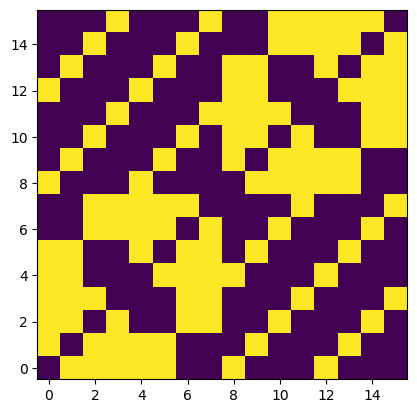

In [315]:
matrix = zeros((n, n))

inhibconnect()

imshow(matrix, origin='lower');

In [316]:
sum(matrix.flatten())/len(matrix.flatten())

0.4375

7/16th of the matrix is inhibitory

In [317]:
exc_matrix = 1 - matrix

si, ti = matrix.nonzero()
se, te = exc_matrix.nonzero()

ratio = 6/16

inh = 0.1
exc = 0.01

In [318]:
# Inhibitory synapses
I1 = Synapses(G1, G1, on_pre='v = out * (1-exp(-(tp * log(1/(1 - g*(v_post - inh)/curr)))/tp))')

# Excitatory synapses
E1 = Synapses(G1, G1, on_pre='v = out * (1-exp(-(tp * log(1/(1 - g*(v_post + exc)/curr)))/tp))')

I1.connect(i=si, j=ti)

E1.connect(i=se, j=te)

M1 = StateMonitor(G1, 'v', record=True)
Sp1 = SpikeMonitor(G1)

In [319]:
run(500*ms)

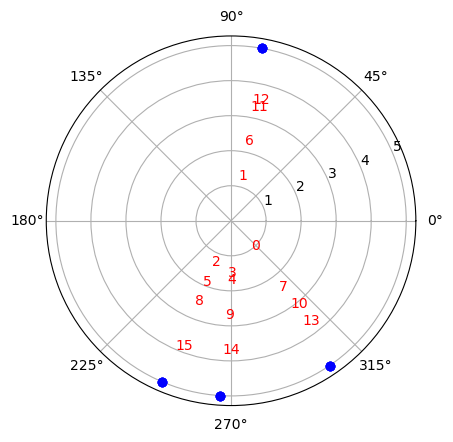

In [320]:
alph = 0.2
t = 4000

for x in range(n):
	polar(M1.v[x][t] * 2*pi, 5, 'bo')
	annotate(x, (M1.v[x][t] * 2*pi, linspace(1, 4, n)[x]), color = 'red')